From [notebooks/04-onnx-export.ipynb](https://github.com/huggingface/transformers/blob/master/notebooks/04-onnx-export.ipynb)

In [17]:
MODEL = 'google/bigbird-roberta-base'
MODEL_PATH = '/storage/onnx/google_bigbird-roberta-base.onnx'
MODEL_OPT = '/storage/onnx/google_bigbird-roberta-base.opt.onnx'

#!rm -rf MODEL_PATH
from pathlib import Path

In [18]:
!rm -rf onnx/
from pathlib import Path
from transformers.convert_graph_to_onnx import convert

# Handles all the above steps for you
convert(framework="pt", model=MODEL, output=Path(f"onnx/{MODEL}.onnx"), opset=11)

# Tensorflow 
# convert(framework="tf", model="bert-base-cased", output="onnx/bert-base-cased.onnx", opset=11)

ONNX opset version set to: 11
Loading pipeline (model: facebook/bart-large-cnn, tokenizer: facebook/bart-large-cnn)
Creating folder onnx/facebook
Using framework PyTorch: 1.6.0+cu101
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch', 1: 'sequence'}
Ensuring inputs are in correct order
decoder_input_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/opt/conda/lib/python3.8/site-packages/transformers/modeling_bart.py:238: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not padding_mask.any():
/opt/conda/lib/python3.8/site-packages/transformers/modeling_bart.py:691: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert embed_dim == self.embed_dim
/opt/conda/lib/python3.8/site-packages/transformers/modeling_bart.py:692: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a const

In [19]:
# # An optional step unless
# # you want to get a model with mixed precision for perf accelartion on newer GPU
# # or you are working with Tensorflow(tf.keras) models or pytorch models other than bert

# !pip install onnxruntime-tools
# from onnxruntime_tools import optimizer

# # Mixed precision conversion for bert-base-cased model converted from Pytorch
# optimized_model = optimizer.optimize_model("bert-base-cased.onnx", model_type='bert', num_heads=12, hidden_size=768)
# optimized_model.convert_model_float32_to_float16()
# optimized_model.save_model_to_file("bert-base-cased.onnx")

# # optimizations for bert-base-cased model converted from Tensorflow(tf.keras)
# optimized_model = optimizer.optimize_model("bert-base-cased.onnx", model_type='bert_keras', num_heads=12, hidden_size=768)
# optimized_model.save_model_to_file("bert-base-cased.onnx")


# optimize transformer-based models with onnxruntime-tools
from onnxruntime_tools import optimizer
from onnxruntime_tools.transformers.onnx_model_bert import BertOptimizationOptions

# disable embedding layer norm optimization for better model size reduction
opt_options = BertOptimizationOptions('bert')
opt_options.enable_embed_layer_norm = False

opt_model = optimizer.optimize_model(
    f'onnx/{MODEL}.onnx',
    'bert', 
    num_heads=12,
    hidden_size=768,
    optimization_options=opt_options)
opt_model.save_model_to_file('bert.opt.onnx')


In [3]:
from os import environ
from psutil import cpu_count

# Constants from the performance optimization available in onnxruntime
# It needs to be done before importing onnxruntime
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

In [4]:
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties that might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

  # Load the model as a graph and prepare the CPU backend 
  session = InferenceSession(model_path, options, providers=[provider])
  session.disable_fallback()
    
  return session


@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

In [36]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)
cpu_model = create_model_for_provider(MODEL_PATH, "CPUExecutionProvider")

# Inputs are provided through numpy array
txt = "ONNX Runtime is a cross-platform inference and training machine-learning accelerator compatible with deep learning frameworks, PyTorch and TensorFlow/Keras, as well as classical machine learning libraries such as scikit-learn, and more."
model_inputs = tokenizer(txt, return_tensors="pt")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

# Run the model (None = get all the outputs)
sequence, pooled = cpu_model.run(None, inputs_onnx)

# Print information about outputs
print(f"Sequence output: {sequence.shape}, Pooled output: {pooled.shape}")
for ids in sequence[0]:
    try:
        print(tokenizer.decode(ids))
    except: pass

Sequence output: (1, 52, 768), Pooled output: (1, 768)


In [41]:
tokenizer

PreTrainedTokenizer(name_or_path='google/bigbird-roberta-base', vocab_size=50358, model_max_len=4096, is_fast=False, padding_side='right', special_tokens={'bos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True)})

# Benchmarking PyTorch model

_Note: PyTorch model benchmark is run on CPU_

In [11]:
from transformers import AutoModel

PROVIDERS = {
    ("cpu", "PyTorch CPU"),
#  Uncomment this line to enable GPU benchmarking
#    ("cuda:0", "PyTorch GPU")
}

results = {}

for device, label in PROVIDERS:
    
    # Move inputs to the correct device
    model_inputs_on_device = {
        arg_name: tensor.to(device)
        for arg_name, tensor in model_inputs.items()
    }

    # Add PyTorch to the providers
    model_pt = AutoModel.from_pretrained(MODEL).to(device)
    for _ in trange(10, desc="Warming up"):
      model_pt(**model_inputs_on_device)

    # Compute 
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
      with track_infer_time(time_buffer):
        model_pt(**model_inputs_on_device)

    # Store the result
    results[label] = OnnxInferenceResult(
        time_buffer, 
        None
    ) 

Tracking inference time on PyTorch: 100%|██████████| 100/100 [00:02<00:00, 35.26it/s]


## Benchmarking PyTorch & ONNX on CPU

_**Disclamer: results may vary from the actual hardware used to run the model**_

In [12]:
PROVIDERS = {
    ("CPUExecutionProvider", "ONNX CPU"),
#  Uncomment this line to enable GPU benchmarking
#     ("CUDAExecutionProvider", "ONNX GPU")
}


for provider, label in PROVIDERS:
    # Create the model with the specified provider
    model = create_model_for_provider(MODEL_PATH, provider)

    # Keep track of the inference time
    time_buffer = []

    # Warm up the model
    model.run(None, inputs_onnx)

    # Compute 
    for _ in trange(100, desc=f"Tracking inference time on {provider}"):
      with track_infer_time(time_buffer):
          model.run(None, inputs_onnx)

    # Store the result
    results[label] = OnnxInferenceResult(
      time_buffer,
      model.get_session_options().optimized_model_filepath
    )

Tracking inference time on CPUExecutionProvider: 100%|██████████| 100/100 [00:01<00:00, 53.58it/s]


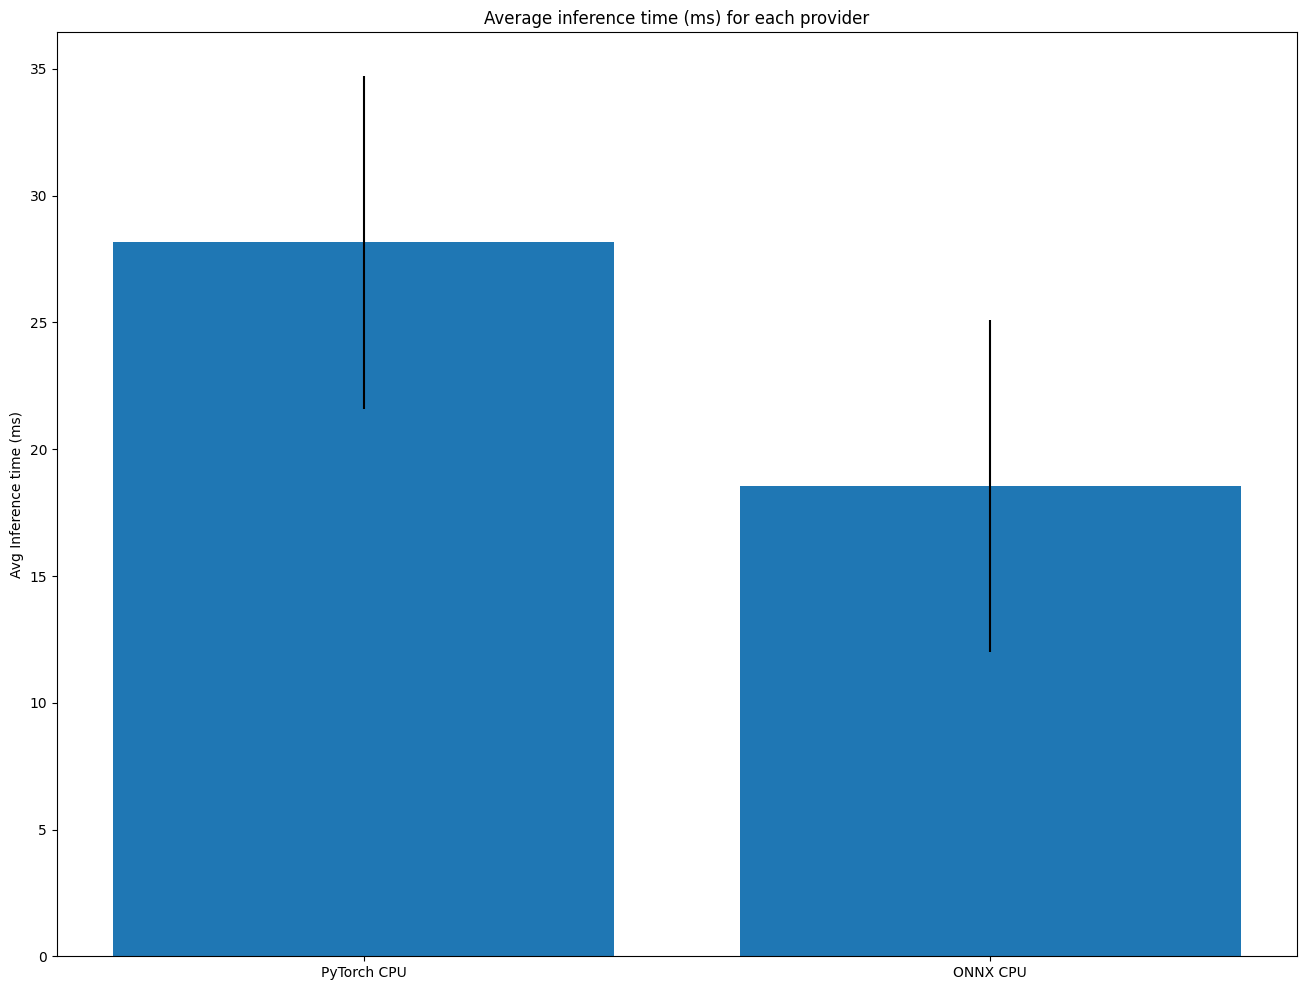

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()

# Quantization support from transformers

Quantization enables the use of integers (_instead of floatting point_) arithmetic to run neural networks models faster. From a high-level point of view, quantization works as mapping the float32 ranges of values as int8 with the less loss in the performances of the model.

Hugging Face provides a conversion tool as part of the transformers repository to easily export quantized models to ONNX Runtime. For more information, please refer to the following: 

- [Hugging Face Documentation on ONNX Runtime quantization supports](https://huggingface.co/transformers/master/serialization.html#quantization)
- [Intel's Explanation of Quantization](https://nervanasystems.github.io/distiller/quantization.html)

With this method, the accuracy of the model remains at the same level than the full-precision model. If you want to see benchmarks on model performances, we recommand reading the [ONNX Runtime notebook](https://github.com/microsoft/onnxruntime/blob/master/onnxruntime/python/tools/quantization/notebooks/Bert-GLUE_OnnxRuntime_quantization.ipynb) on the subject.

# Benchmarking PyTorch quantized model

In [14]:
import torch 

# Quantize
model_pt_quantized = torch.quantization.quantize_dynamic(
    model_pt.to("cpu"), {torch.nn.Linear}, dtype=torch.qint8
)

# Warm up 
model_pt_quantized(**model_inputs)

# Benchmark PyTorch quantized model
time_buffer = []
for _ in trange(100):
    with track_infer_time(time_buffer):
        model_pt_quantized(**model_inputs)
    
results["PyTorch CPU Quantized"] = OnnxInferenceResult(
    time_buffer,
    None
)

100%|██████████| 100/100 [00:01<00:00, 70.56it/s]


In [47]:
model_inputs

{'input_ids': tensor([[   65,   541,  6245,   156, 43261,   419,   358,  3373,   113, 24355,
         32379,   391,  3148,  4673,   113, 40785, 44320, 11771,   452,  2870,
          4774, 29352,   112,  9586, 15985,   455,   391,   410, 22955, 37636,
           115,  8997,  8948,   112,   456,   981,   456, 16094,  4673,  4774,
         12883,   985,   456, 20782, 15914,   113, 35821,   112,   391,   618,
           114,    66]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [52]:
res = model_pt_quantized.generate(**model_inputs)
tokenizer.decode(res[0])

Input length of input_ids is 52, but ``max_length`` is set to 20.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


'[CLS] ONNX Runtime is a cross-platform inference and training machine-learning accelerator compatible with deep learning frameworks, PyTorch and TensorFlow/Keras, as well as classical machine learning libraries such as scikit-learn, and more.[SEP]'

# Benchmarking ONNX quantized model

In [19]:
from transformers.convert_graph_to_onnx import quantize

# Transformers allow you to easily convert float32 model to quantized int8 with ONNX Runtime
quantized_model_path = quantize(Path(MODEL_PATH))

# Then you just have to load through ONNX runtime as you would normally do
quantized_model = create_model_for_provider(quantized_model_path.as_posix(), "CPUExecutionProvider")

# Warm up the overall model to have a fair comparaison
outputs = quantized_model.run(None, inputs_onnx)

# Evaluate performances
time_buffer = []
for _ in trange(100, desc=f"Tracking inference time on CPUExecutionProvider with quantized model"):
    with track_infer_time(time_buffer):
        outputs = quantized_model.run(None, inputs_onnx)

# Store the result
results["ONNX CPU Quantized"] = OnnxInferenceResult(
    time_buffer, 
    quantized_model_path
) 

         Please use quantize_static for static quantization, quantize_dynamic for dynamic quantization.


As of onnxruntime 1.4.0, models larger than 2GB will fail to quantize due to protobuf constraint.
This limitation will be removed in the next release of onnxruntime.
Quantized model has been written at /storage/onnx/google_bigbird-roberta-base-quantized.onnx: ✔


Tracking inference time on CPUExecutionProvider with quantized model: 100%|██████████| 100/100 [00:01<00:00, 88.19it/s]


## Show the inference performance of each providers 

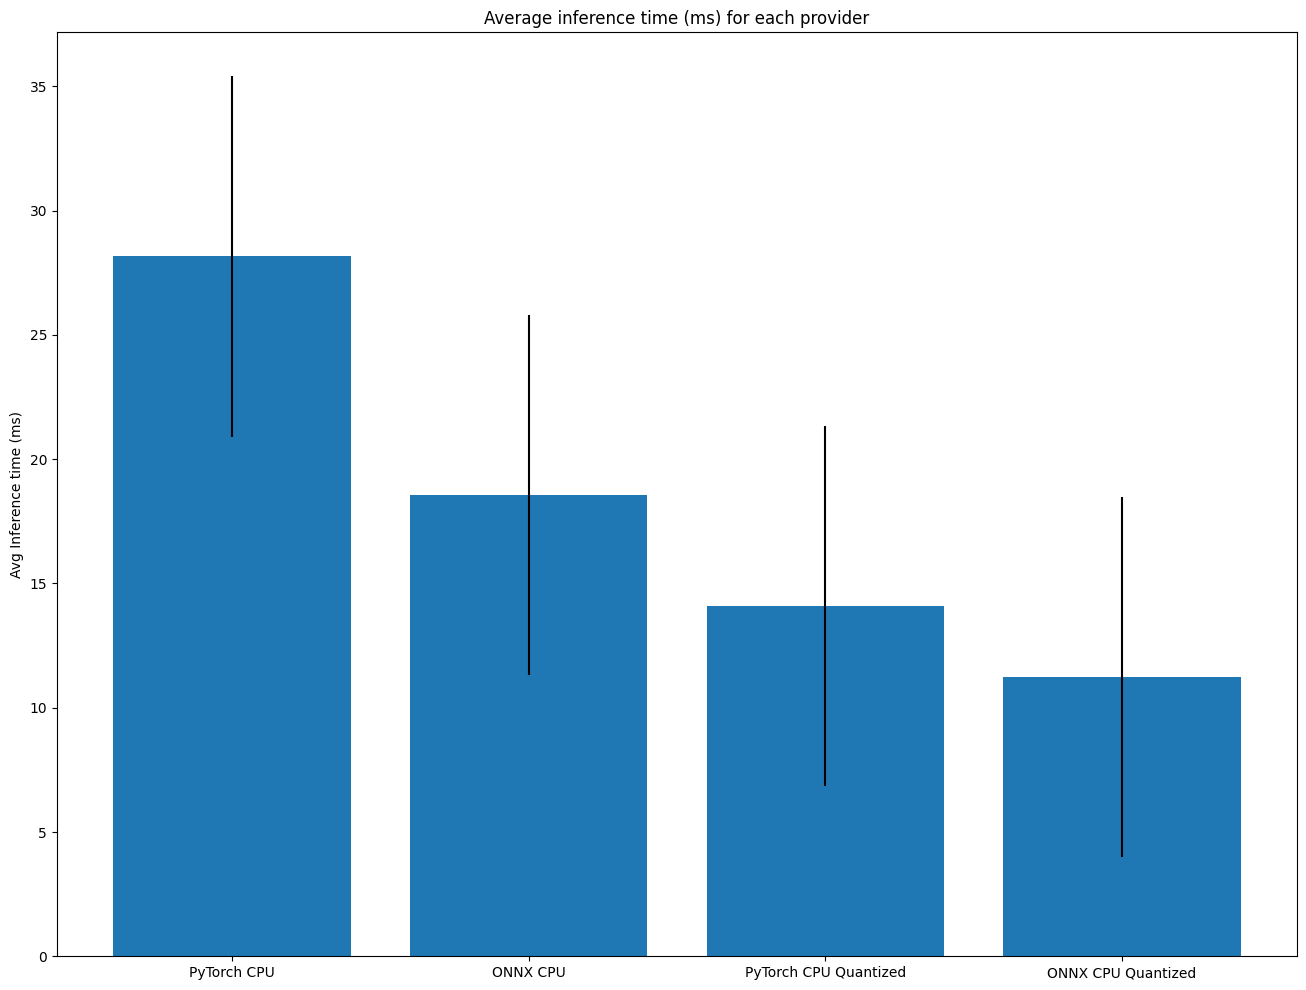

In [20]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os


# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_ylabel("Avg Inference time (ms)")
ax.set_title("Average inference time (ms) for each provider")
ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
plt.show()